## Portfolio Exercise: Starbucks
<br>

<img src="https://opj.ca/wp-content/uploads/2018/02/New-Starbucks-Logo-1200x969.jpg" width="200" height="200">
<br>
<br>
 
#### Background Information

The dataset you will be provided in this portfolio exercise was originally used as a take-home assignment provided by Starbucks for their job candidates. The data for this exercise consists of about 120,000 data points split in a 2:1 ratio among training and test files. In the experiment simulated by the data, an advertising promotion was tested to see if it would bring more customers to purchase a specific product priced at $10. Since it costs the company 0.15 to send out each promotion, it would be best to limit that promotion only to those that are most receptive to the promotion. Each data point includes one column indicating whether or not an individual was sent a promotion for the product, and one column indicating whether or not that individual eventually purchased that product. Each individual also has seven additional features associated with them, which are provided abstractly as V1-V7.

#### Optimization Strategy

Your task is to use the training data to understand what patterns in V1-V7 to indicate that a promotion should be provided to a user. Specifically, your goal is to maximize the following metrics:

* **Incremental Response Rate (IRR)** 

IRR depicts how many more customers purchased the product with the promotion, as compared to if they didn't receive the promotion. Mathematically, it's the ratio of the number of purchasers in the promotion group to the total number of customers in the purchasers group (_treatment_) minus the ratio of the number of purchasers in the non-promotional group to the total number of customers in the non-promotional group (_control_).

$$ IRR = \frac{purch_{treat}}{cust_{treat}} - \frac{purch_{ctrl}}{cust_{ctrl}} $$


* **Net Incremental Revenue (NIR)**

NIR depicts how much is made (or lost) by sending out the promotion. Mathematically, this is 10 times the total number of purchasers that received the promotion minus 0.15 times the number of promotions sent out, minus 10 times the number of purchasers who were not given the promotion.

$$ NIR = (10\cdot purch_{treat} - 0.15 \cdot cust_{treat}) - 10 \cdot purch_{ctrl}$$

For a full description of what Starbucks provides to candidates see the [instructions available here](https://drive.google.com/open?id=18klca9Sef1Rs6q8DW4l7o349r8B70qXM).

Below you can find the training data provided.  Explore the data and different optimization strategies.

#### How To Test Your Strategy?

When you feel like you have an optimization strategy, complete the `promotion_strategy` function to pass to the `test_results` function.  
From past data, we know there are four possible outomes:

Table of actual promotion vs. predicted promotion customers:  

<table>
<tr><th></th><th colspan = '2'>Actual</th></tr>
<tr><th>Predicted</th><th>Yes</th><th>No</th></tr>
<tr><th>Yes</th><td>I</td><td>II</td></tr>
<tr><th>No</th><td>III</td><td>IV</td></tr>
</table>

The metrics are only being compared for the individuals we predict should obtain the promotion – that is, quadrants I and II.  Since the first set of individuals that receive the promotion (in the training set) receive it randomly, we can expect that quadrants I and II will have approximately equivalent participants.  

Comparing quadrant I to II then gives an idea of how well your promotion strategy will work in the future. 

Get started by reading in the data below.  See how each variable or combination of variables along with a promotion influences the chance of purchasing.  When you feel like you have a strategy for who should receive a promotion, test your strategy against the test dataset used in the final `test_results` function.

In [2]:
# load in packages
from itertools import combinations

from test_results import test_results, score#, valid_results 
import numpy as np
import pandas as pd
import scipy as sp
import sklearn as sk
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize

import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

In [3]:
# Cells for you to work and document as necessary - 
# definitely feel free to add more cells as you need

In [4]:
# load in the data
train_data = pd.read_csv('./training.csv')
train_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,1,No,0,2,30.443518,-1.165083,1,1,3,2
1,3,No,0,3,32.159350,-0.645617,2,3,2,2
2,4,No,0,2,30.431659,0.133583,1,1,4,2
3,5,No,0,0,26.588914,-0.212728,2,1,4,2
4,8,Yes,0,3,28.044332,-0.385883,1,1,2,2


In [5]:
# check number of missing values per column
train_data.isnull().mean()

ID           0.0
Promotion    0.0
purchase     0.0
V1           0.0
V2           0.0
V3           0.0
V4           0.0
V5           0.0
V6           0.0
V7           0.0
dtype: float64

In [6]:
test_data = pd.read_csv('./Test.csv')
test_data.head(7)

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,2,No,0,1,41.376390,1.172517,1,1,2,2
1,6,Yes,0,1,25.163598,0.653050,2,2,2,2
2,7,Yes,0,1,26.553778,-1.597972,2,3,4,2
3,10,No,0,2,28.529691,-1.078506,2,3,2,2
4,12,No,0,2,32.378538,0.479895,2,2,1,2
5,13,Yes,0,0,32.566788,-1.684550,2,1,2,1
6,19,No,0,2,29.833921,-1.078506,1,2,3,2


In [7]:
features = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7']

In [8]:
train_data['Promotion'].value_counts()

Yes    42364
No     42170
Name: Promotion, dtype: int64

In [9]:
train_data['purchase'].value_counts()

0    83494
1     1040
Name: purchase, dtype: int64

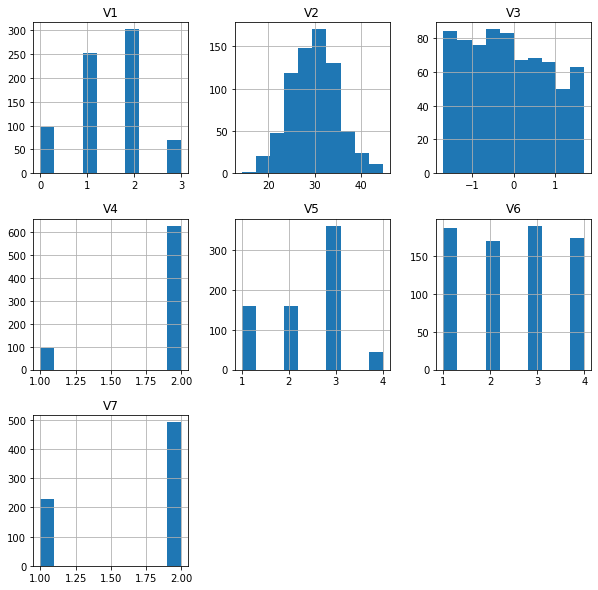

In [10]:
# how the features of promotional and purchaser people look like?

train_data[(train_data['Promotion']=='Yes') & (train_data['purchase']==1)][features].hist(figsize=(10,10));

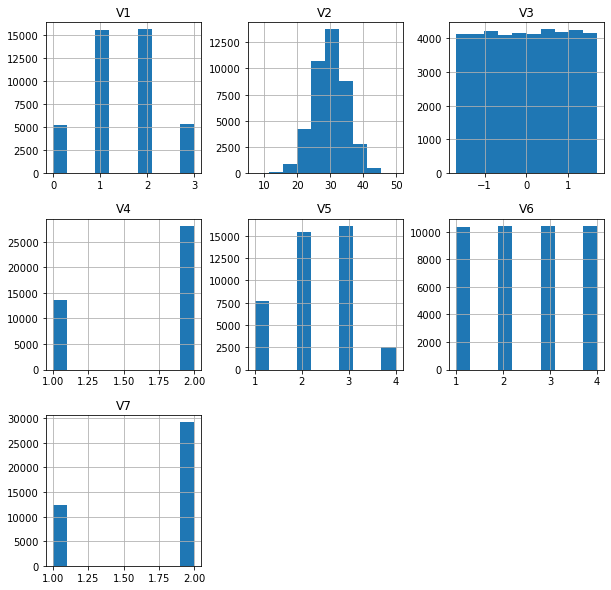

In [11]:
# how the features of promotional and non-purchaser people look like?

train_data[(train_data['Promotion']=='Yes') & (train_data['purchase']==0)][features].hist(figsize=(10,10));

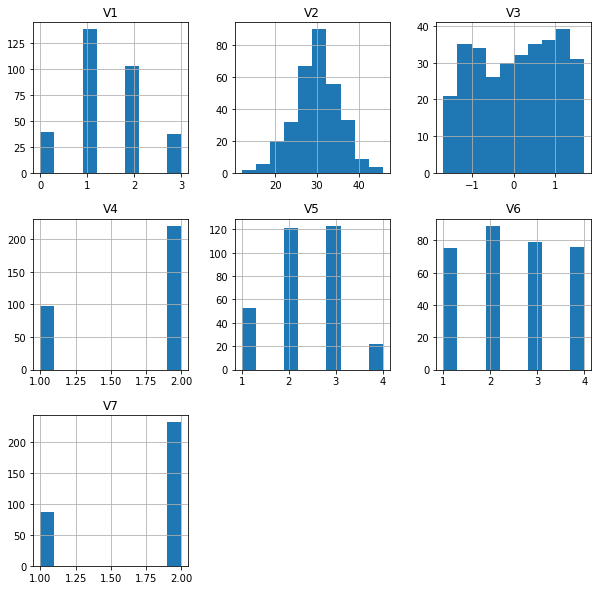

In [12]:
# non-promotional and purchaser

train_data[(train_data['Promotion']=='No') & (train_data['purchase']==1)][features].hist(figsize=(10,10));

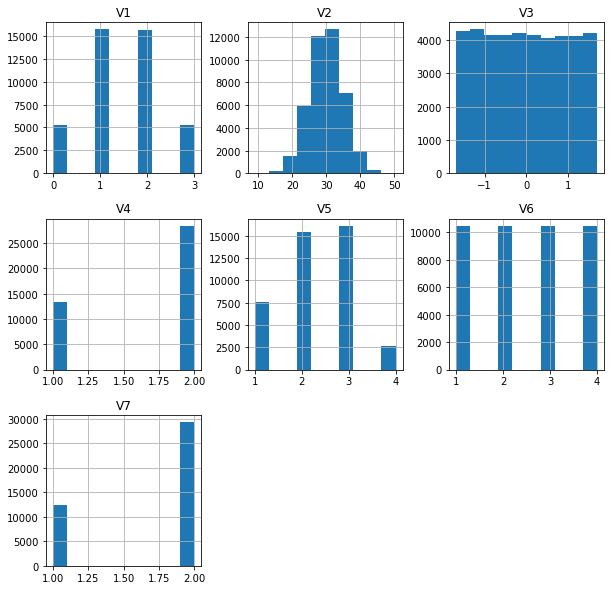

In [13]:
# non promotional and non purchaser
train_data[(train_data['Promotion']=='No') & (train_data['purchase']==0)][features].hist(figsize=(10,10));

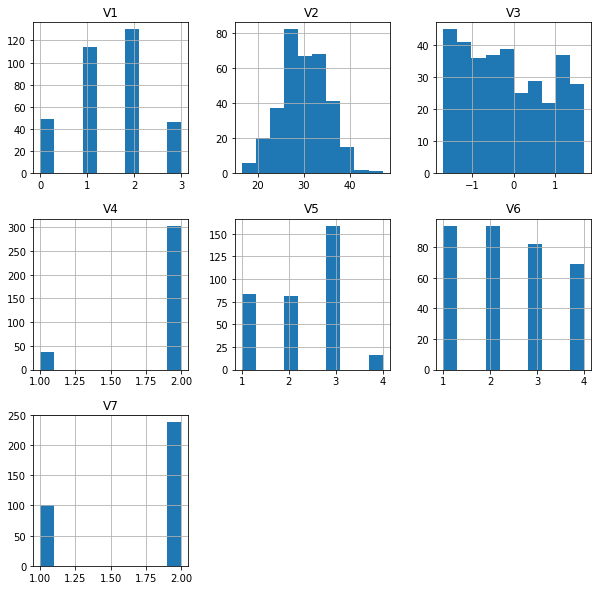

In [12]:
test_data[(test_data['Promotion']=='Yes') & (test_data['purchase']==1)][features].hist(figsize=(10,10));

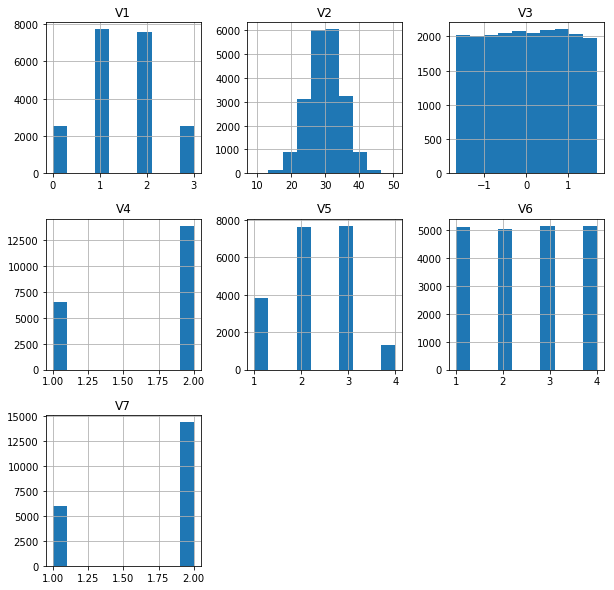

In [13]:
test_data[(test_data['Promotion']=='Yes') & (test_data['purchase']==0)][features].hist(figsize=(10,10));

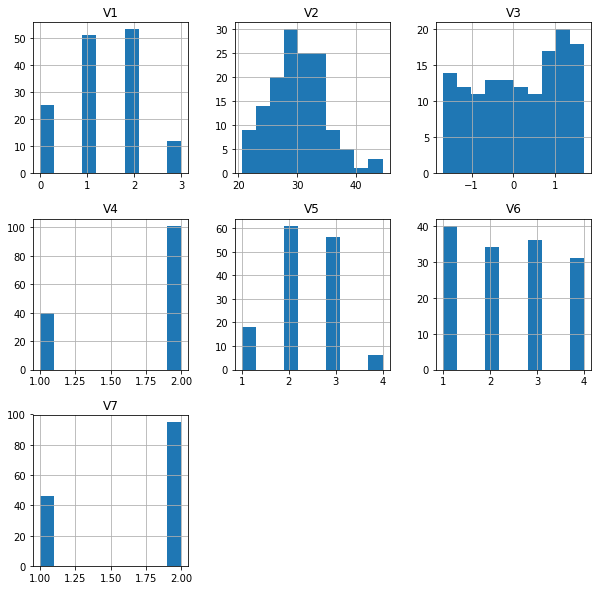

In [14]:
test_data[(test_data['Promotion']=='No') & (test_data['purchase']==1)][features].hist(figsize=(10,10));

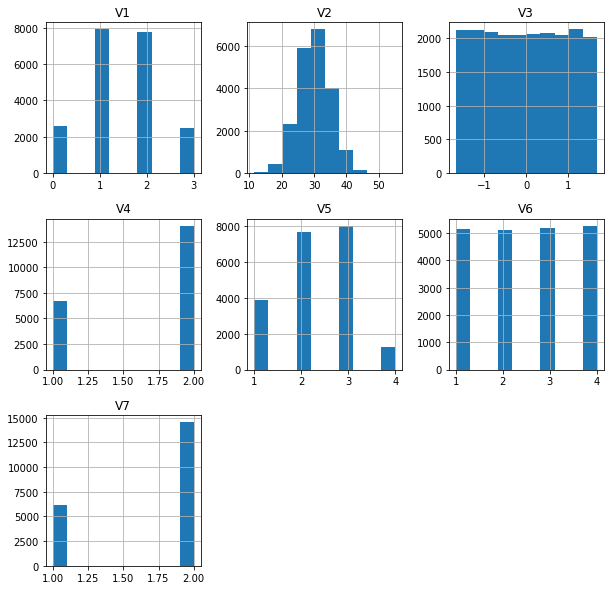

In [15]:
test_data[(test_data['Promotion']=='No') & (test_data['purchase']==0)][features].hist(figsize=(10,10));

In [14]:
# testing baseline model, where we send promotions to everyone

def promotion_strategy(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]            
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    test = df
    
    promotion = []
    
    num_test_points = test.shape[0]
    
    for i in range(num_test_points):
        promotion.append('Yes')
        
    promotion = np.array(promotion)
    
    return promotion

In [15]:
# This will test your results, and provide you back some information 
# on how well your promotion_strategy will work in practice

test_results(promotion_strategy)

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0096.

Your nir with this strategy is -1132.20.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.009593158278250108, -1132.1999999999998)

In [6]:
# Check sample size needed for control and treatment groups
NormalIndPower().solve_power(effect_size = proportion_effectsize(.0096, .015), alpha = .05, power = 0.8,
                             alternative = 'smaller')

5089.265513625437

In [14]:
# calculate our current treatment group size
train_data[train_data['Promotion']=='Yes'].shape[0]

42364

In [15]:
# calculate our current control group size
train_data[train_data['Promotion']=='No'].shape[0]

42170

In [18]:
test_data[test_data['Promotion']=='Yes'].shape[0]

20748

In [17]:
test_data[test_data['Promotion']=='No'].shape[0]

20902

If we were to send everyone a promotion, our IRR is 0.96\% and NIR is -\\$1,132.20. This will be the baseline model. Hence, blindly sending everyone a promotion is going to lose the company a lot of money.

Our baseline IRR is 0.96\%. If our desired minimum IRR is 1.5\% (an 0.081\% absolute increase in IRR), and we want to detect this change with a type 1 error rate of 0.05 and a power of 0.80, we will need a sample size of approximately 5,090 in each group (both control and treatment). Since, we have more than 40,000 data points in each group, we have sufficient data

## Model 1: Predict only for indivduals who received promotions and purchased

In this approach, we will assign labels of 1 to those who received the promotions and made purchases, and labels of 0 to everyone else. In other words, we want the model to find the individuals who are likely to purchase only after they received a promotion. This is a simple model that surprisingly performed relatively well for this dataset, generating an incremental response rate (irr) of 2.19\% and a net incrmental revenue (nlr) of \\$332.70. This actually outperformed the Starbuck's model for this dataset, which was an irr of 1.88\% and an nlr of \\$189.45. However, since the irr and nlr on the validation set is lower at 1.93\% and \\$94.70,the model's relatively good performance on the test set may be due to random chance. Overall, it still performed superbly for such a simple model.

In [19]:
# read data
train_data = pd.read_csv('./training.csv')
test_data = pd.read_csv('./Test.csv')

In [20]:
# generate labels
# only those who made a purchase after receiving a promotion will be assigned a label of 1, 
# while the other individuals will be given a label of 0

response = []

for index, row in train_data.iterrows():
    if (row['purchase'] == 1) and (row['Promotion']=='Yes'):
        response.append(1.0)
    else:
        response.append(0.0)
        
train_data['response'] = response

In [21]:
train_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7,response
0,1,No,0,2,30.443518,-1.165083,1,1,3,2,0.0
1,3,No,0,3,32.159350,-0.645617,2,3,2,2,0.0
2,4,No,0,2,30.431659,0.133583,1,1,4,2,0.0
3,5,No,0,0,26.588914,-0.212728,2,1,4,2,0.0
4,8,Yes,0,3,28.044332,-0.385883,1,1,2,2,0.0


In [22]:
# split data into train and valid
train, valid = sk.model_selection.train_test_split(train_data, test_size=0.2,random_state=42)

In [23]:
# generate features and labels
Y_train = train['response']
X_train = train[features]

Y_valid = valid['response']
X_valid = valid[features]

In [24]:
Y_train.value_counts()

0.0    67047
1.0      580
Name: response, dtype: int64

In [30]:
# up sample only the train dataset with SMOTE
sm = SMOTE(random_state=42)
X_train_upsamp, Y_train_upsamp = sm.fit_resample(X_train, Y_train)
    
X_train_upsamp = pd.DataFrame(X_train_upsamp, columns=features)

Y_train_upsamp = pd.Series(Y_train_upsamp)
Y_train_upsamp.value_counts()

1.0    67047
0.0    67047
Name: response, dtype: int64

In [31]:
# Train an xgboost model
eval_set = [(X_train_upsamp, Y_train_upsamp), (X_valid, Y_valid)]
model = xgb.XGBClassifier(learning_rate = 0.1,\
                          max_depth = 7,\
                          min_child_weight = 5,\
                          objective = 'binary:logistic',\
                          seed = 42,\
                          gamma = 0.1,\
                          silent = True)
model.fit(X_train_upsamp, Y_train_upsamp, eval_set=eval_set,\
          eval_metric="auc", verbose=True, early_stopping_rounds=30)

C:\Users\Phuong\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:25:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.74629	validation_1-auc:0.56087
[1]	validation_0-auc:0.77346	validation_1-auc:0.56746
[2]	validation_0-auc:0.77602	validation_1-auc:0.56480
[3]	validation_0-auc:0.77910	validation_1-auc:0.56450
[4]	validation_0-auc:0.79753	validation_1-auc:0.55870
[5]	validation_0-auc:0.79829	validation_1-auc:0.56814
[6]	validation_0-auc:0.81814	validation_1-auc:0.57547
[7]	validation_0-auc:0.81955	validation_1-auc:0.57279
[8]	validation_0-auc:0.82778	validation_1-auc:0.57008
[9]	validation_0-auc:0.83510	validation_1-auc:0.57113
[10]	validation_0-auc:0.83851	validation_1-auc:0.57553
[11]	validation_0-auc

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=5, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              silent=True, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

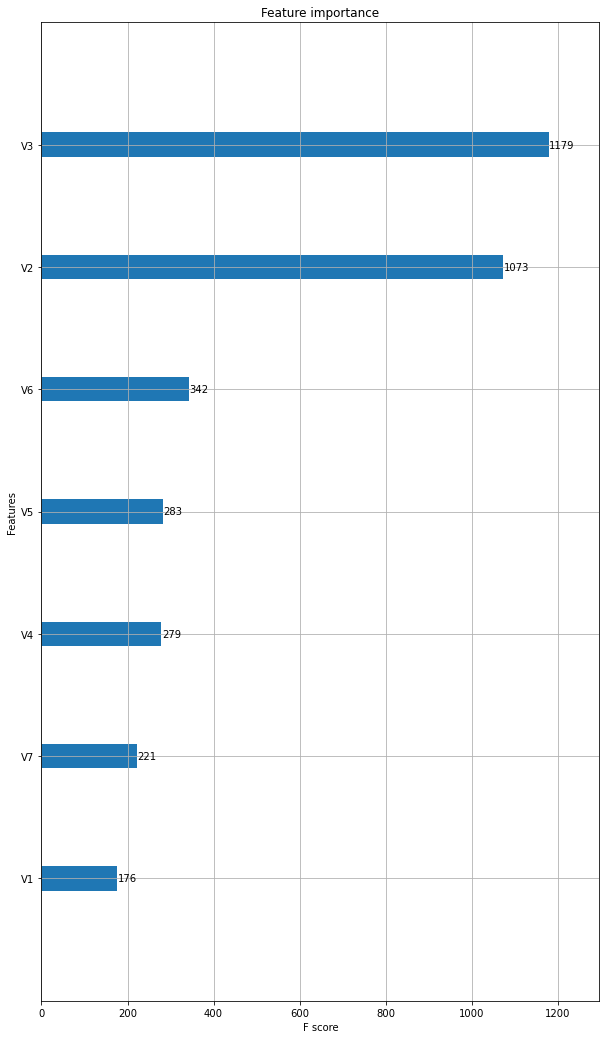

In [32]:
# check which features are important

from xgboost import plot_importance
from matplotlib import pyplot

fig, ax = pyplot.subplots(figsize=(10, 18));
xgb.plot_importance(model, ax=ax);

In [33]:
# confusion matrix
valid_pred = model.predict(X_valid, ntree_limit=model.best_ntree_limit)
cm = sk.metrics.confusion_matrix
cm(Y_valid, valid_pred)

array([[12769,  3997],
       [   96,    45]], dtype=int64)

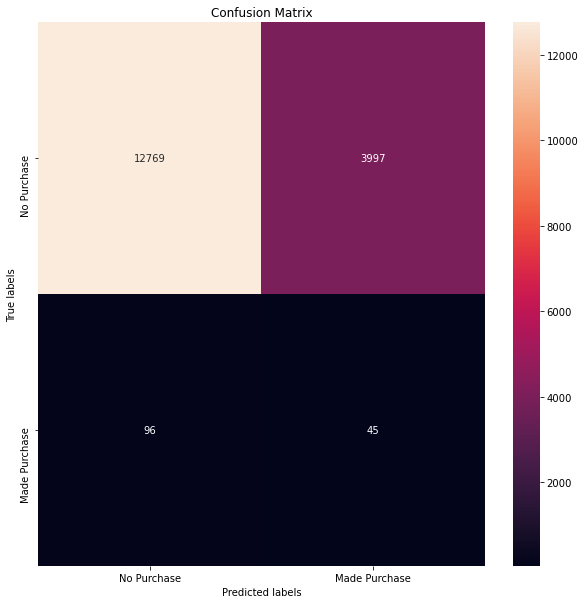

In [34]:
# confusion marix for the validation set
valid_pred = model.predict(X_valid, ntree_limit=model.best_ntree_limit)
cm = sk.metrics.confusion_matrix(Y_valid, valid_pred)

fig, ax= plt.subplots(figsize=(10,10))
sb.heatmap(cm, annot=True, fmt='g', ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['No Purchase', 'Made Purchase']); 
ax.yaxis.set_ticklabels(['No Purchase', 'Made Purchase']);

In [35]:
def promotion_strategy(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]
                
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    test = df
    
    preds = model.predict(test, ntree_limit=model.best_ntree_limit)

    promotion = []
    for pred in preds:
        if pred == 1:
            promotion.append('Yes')
        else:
            promotion.append('No')
    promotion = np.array(promotion)
    return promotion

In [37]:
test_results(promotion_strategy)

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0188.

Your nir with this strategy is 181.90.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.01880489698332953, 181.89999999999998)

## Model 2: Using Two Models

In this approach, we will train two models. One model will be trained on the treatment group (those who received the promotion) and we will refer to this model as the treatment model. Another model will be trained on the control group (those who did not received the promotion), and we will refer to this as the control model. The target of both models will be whether the individual made the purchase or not. The treatment model will predict the probability that individual will make a purchase if he or she received the promotion, while the control model will predict the probability that individual will make a purchase if he or she did not receive the promotion. Ideally the difference in the probabilities, which we will call the lift:

$$ Lift = P(purchase | treatment) - P(purchase | control) $$

will tell us the probability that sending a promotion to an individual will increase his or her willingness to make a purhcase vs not sending a promotion. We can then send promotions to individuals with lift values higher than a pre-defined cutoff percentile. For example, we can send promotions to individuals in the top 3 deciles.

For this dataset, we can manually try a few cutoff percentiles or perform a grid search to find the optimal cut-off percentile. In this example, a manual search was conducted for simplicity sake. The performance of this model left a lot to be desired. Sending out promotions to individuals with lift values above the 97th percentile seems to be one of the better option. An irr of 0.44\% and nlr of \\$26.90 is achieved on the validation set. On the other hand, an irr of 1.76\% and nlr of \\$12.70 is achieved for the test data, which is not as good as the Starbuck's model. It should also be noted that this method is extremely sensitive to changes in the cut-off percentile used for this dataset. Both the addition or subtraction of a few percentiles resulted in drastically different nlr. Hence, the two model approach is not recommended for this data set.

As noted in the presentation on Uplift Modeling by Victor Lo found [here](https://www.slideshare.net/odsc/victor-lomachinelearningpresentation), one of the disadvantages of this method is that it indirectly models uplift. The difference between the treatment and control probabilities may sometimes be noise. In addition, there is also the possibility that the scales of both models don't match.

In [135]:
# read data
train_data = pd.read_csv('./training.csv')
test_data = pd.read_csv('./Test.csv')

In [136]:
# split data into train and valid
train, valid = sk.model_selection.train_test_split(train_data, test_size=0.2,random_state=42)

In [137]:
features = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7']

# Generate validation data
# one for control group, another for treatment group
valid_control = valid[valid['Promotion']=='No']
Y_valid_control = valid_control['purchase']
X_valid_control = valid_control[features]

valid_exper = valid[valid['Promotion']=='Yes']
Y_valid_exper = valid_exper['purchase']
X_valid_exper = valid_exper[features]

In [138]:
# generate training data
train_control = train[train['Promotion']=='No']
Y_train_control = train_control['purchase']
X_train_control = train_control[features]

train_exper = train[train['Promotion']=='Yes']
Y_train_exper = train_exper['purchase']
X_train_exper = train_exper[features]

In [139]:
# up-sample training data with SMOTE
sm = SMOTE(random_state=42, ratio = 1.0)

# up-sample control group
X_train_control_upsamp, Y_train_control_upsamp = sm.fit_sample(X_train_control, Y_train_control)
X_train_control_upsamp = pd.DataFrame(X_train_control_upsamp, columns=features)
Y_train_control_upsamp = pd.Series(Y_train_control_upsamp)

# up-sample treatment group
X_train_exper_upsamp, Y_train_exper_upsamp = sm.fit_sample(X_train_exper, Y_train_exper)    
X_train_exper_upsamp = pd.DataFrame(X_train_exper_upsamp, columns=features)
Y_train_exper_upsamp = pd.Series(Y_train_exper_upsamp)

In [112]:
# train control model
eval_set = [(X_train_control_upsamp, Y_train_control_upsamp), (X_valid_control, Y_valid_control)]
model_control = xgb.XGBClassifier(learning_rate = 0.1,\
                                  max_depth = 7,\
                                  min_child_weight = 5,\
                                  objective = 'binary:logistic',\
                                  seed = 42,\
                                  gamma = 1,\
                                  #colsample_bytree = 0.1,\
                                  silent = True)
model_control.fit(X_train_control_upsamp, Y_train_control_upsamp, eval_set=eval_set,\
                    eval_metric="auc", verbose=True, early_stopping_rounds=30)

[0]	validation_0-auc:0.927669	validation_1-auc:0.520814
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.929149	validation_1-auc:0.521929
[2]	validation_0-auc:0.958296	validation_1-auc:0.526606
[3]	validation_0-auc:0.959648	validation_1-auc:0.519001
[4]	validation_0-auc:0.960095	validation_1-auc:0.520977
[5]	validation_0-auc:0.982338	validation_1-auc:0.514844
[6]	validation_0-auc:0.98125	validation_1-auc:0.510661
[7]	validation_0-auc:0.982303	validation_1-auc:0.507793
[8]	validation_0-auc:0.984336	validation_1-auc:0.501206
[9]	validation_0-auc:0.985167	validation_1-auc:0.497971
[10]	validation_0-auc:0.988254	validation_1-auc:0.503657
[11]	validation_0-auc:0.988485	validation_1-auc:0.50131
[12]	validation_0-auc:0.988038	validation_1-auc:0.501582
[13]	validation_0-auc:0.989287	validation_1-auc:0.499816
[14]	validation_0-auc:0.989877	validation_1-auc:0.497989


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=1, learning_rate=0.1, max_delta_step=0,
       max_depth=7, min_child_weight=5, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42, silent=True,
       subsample=1)

In [113]:
# train treatment model
eval_set = [(X_train_exper_upsamp, Y_train_exper_upsamp), (X_valid_exper, Y_valid_exper)]
model_exper = xgb.XGBClassifier(learning_rate = 0.1,\
                                max_depth = 7,\
                                min_child_weight = 5,\
                                objective = 'binary:logistic',\
                                seed = 42,\
                                gamma = 1,\
                                #colsample_bytree = 0.1,\
                                silent = True)
model_exper.fit(X_train_exper_upsamp, Y_train_exper_upsamp, eval_set=eval_set,\
                eval_metric="auc", verbose=True, early_stopping_rounds=30)

[0]	validation_0-auc:0.890697	validation_1-auc:0.649396
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.896733	validation_1-auc:0.649055
[2]	validation_0-auc:0.905555	validation_1-auc:0.653715
[3]	validation_0-auc:0.914605	validation_1-auc:0.653078
[4]	validation_0-auc:0.916028	validation_1-auc:0.655472
[5]	validation_0-auc:0.930728	validation_1-auc:0.65128
[6]	validation_0-auc:0.937276	validation_1-auc:0.648748
[7]	validation_0-auc:0.939903	validation_1-auc:0.649826
[8]	validation_0-auc:0.941034	validation_1-auc:0.648604
[9]	validation_0-auc:0.945493	validation_1-auc:0.648523
[10]	validation_0-auc:0.952592	validation_1-auc:0.649349
[11]	validation_0-auc:0.953901	validation_1-auc:0.646883
[12]	validation_0-auc:0.960077	validation_1-auc:0.646123
[13]	validation_0-auc:0.962863	validation_1-auc:0.643048
[14]	validation_0-auc:0.963443	validation_1-auc:0.642786

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=1, learning_rate=0.1, max_delta_step=0,
       max_depth=7, min_child_weight=5, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42, silent=True,
       subsample=1)

In [114]:
# make predictions on the validation data sets for both models
control_valid_pred = model_control.predict(X_valid_control, ntree_limit=model_control.best_ntree_limit)
exper_valid_pred = model_exper.predict(X_valid_exper, ntree_limit=model_exper.best_ntree_limit)

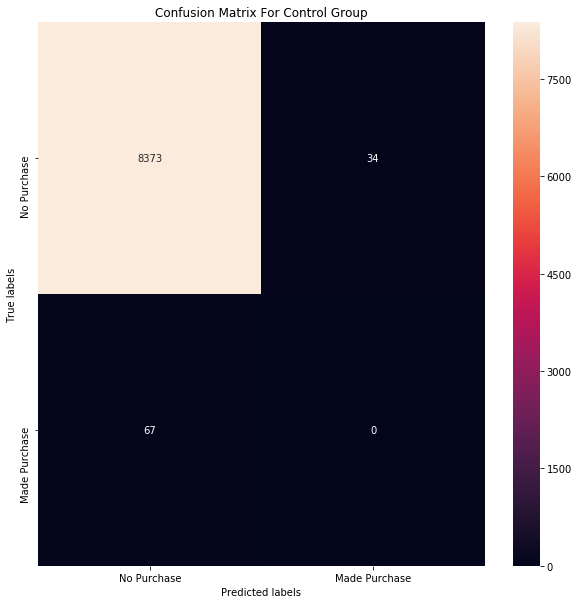

In [117]:
# confusion marix for thge validation set
valid_pred = model.predict(X_valid, ntree_limit=model.best_ntree_limit)
cm = sk.metrics.confusion_matrix(Y_valid_control, control_valid_pred)

fig, ax= plt.subplots(figsize=(10,10))
sb.heatmap(cm, annot=True, fmt='g', ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix For Control Group'); 
ax.xaxis.set_ticklabels(['No Purchase', 'Made Purchase']); 
ax.yaxis.set_ticklabels(['No Purchase', 'Made Purchase']);

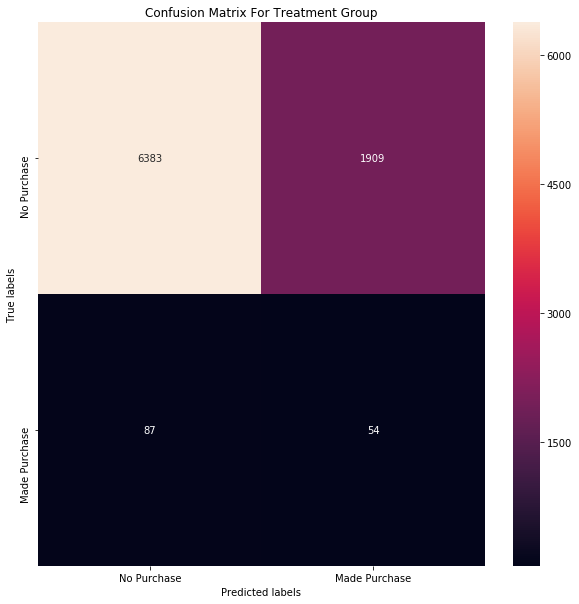

In [116]:
# confusion marix for thge validation set
valid_pred = model.predict(X_valid, ntree_limit=model.best_ntree_limit)
cm = sk.metrics.confusion_matrix(Y_valid_exper, exper_valid_pred)

fig, ax= plt.subplots(figsize=(10,10))
sb.heatmap(cm, annot=True, fmt='g', ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix For Treatment Group'); 
ax.xaxis.set_ticklabels(['No Purchase', 'Made Purchase']); 
ax.yaxis.set_ticklabels(['No Purchase', 'Made Purchase']);

In [118]:
def promotion_strategy(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]            
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    test = df
    
    pred_probs_contol = model_control.predict_proba(test, ntree_limit=model_control.best_ntree_limit)

    pred_probs_exper = model_exper.predict_proba(test, ntree_limit=model_exper.best_ntree_limit)

    # get difference in probabilities between experimental and cpntrol model for purchase = 1 label
    lift = pred_probs_exper[:,1] - pred_probs_contol[:,1]
    
    promotion = []
    
    # Only send promotions to top 3 percentile of probabilities
    cutoff_lift = np.percentile(lift, 97)
    
    for prob in lift:
        if prob > 0:
            if prob > cutoff_lift:
                promotion.append('Yes')
        else:
            promotion.append('No')

    promotion = np.array(promotion)
    
    return promotion

In [119]:
# find out irr and nlr on our validation set
valid_results(promotion_strategy, valid)

Nice job!  See how well your strategy worked on our valid data below!

Your irr with this strategy is 0.0044.

Your nir with this strategy is -26.90.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.004443183966723389, -26.9)

In [120]:
# This will test your results, and provide you back some information 
# on how well your promotion_strategy will work in practice

test_results(promotion_strategy)

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0176.

Your nir with this strategy is 12.70.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.0176197886273747, 12.700000000000003)

## Model 3: Using Treatment Dummy Approach

In this approach, a single model is used to model the data. Unlike the approach used in the first model, this approach adds an additional indicator variable to track if an individual is in a treatment or control group during training. Any individuals who made purchases will be given a label of 1, irregradless of whether he or she is in the control or treatment group. 

To predict whether a new individual in a test set is likely to make a purhcase only after receiving a promotion, we can first calculate the probability that the individual will make a purchase if he or she is in the treatment group by setting the treatment indicator as 1. Next, we calculate the probability that the individual will make a purchase if he or she is in the control group by setting the treatment indicator as 0. The difference in the two probabilities will be the lift value, aka, how positively influenced the individual is as a result of the treatment (receiving promotion):

$$Lift = P(purchase | I_{treat} = 1) - P(purchase |  I_{treat} = 0)$$

We can opt to send promotions to individuals with prostive lift values. Using this approach for this dataset, an irr of 1.42\% and an nlr of -\\$47.40 is obtained for the validation set. On the other hand, the irr and nlr values for the test set is 1.54\% and \\$42.60 respectively. Such a drastic difference between the validation and test nlrs is certainly surprising. The test results does seem to suggest that this is could be a relatively good approach as well. Alternative models, new feature generation and alternative upsampling methods could be tried to improve the results. In addition, you can also choose to send promotions only to individuals with lift values above a certain percentile.

This approach is a slight modification of the method proposed by Victor Lo in the previously mentioned presentation, which can be found [here](https://www.slideshare.net/odsc/victor-lomachinelearningpresentation). The original method proposes a logistic regression model.

In [140]:
train_data = pd.read_csv('./training.csv')
test_data = pd.read_csv('./Test.csv')

In [141]:
# encode Promotion as 0 or 1 indicator variable
train_data['treatment'] = np.where(train_data['Promotion'] == "Yes", 1, 0)
train_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7,treatment
0,1,No,0,2,30.443518,-1.165083,1,1,3,2,0
1,3,No,0,3,32.159350,-0.645617,2,3,2,2,0
2,4,No,0,2,30.431659,0.133583,1,1,4,2,0
3,5,No,0,0,26.588914,-0.212728,2,1,4,2,0
4,8,Yes,0,3,28.044332,-0.385883,1,1,2,2,1


In [142]:
train, valid = sk.model_selection.train_test_split(train_data, test_size=0.2,random_state=42)

features = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'treatment']

Y_train = train['purchase']
X_train = train[features]

Y_valid = valid['purchase']
X_valid = valid[features]

In [143]:
# up sample with SMOTE
sm = SMOTE(random_state=42, ratio = 1.0)
X_train_upsamp, Y_train_upsamp = sm.fit_sample(X_train, Y_train)
    
X_train_upsamp = pd.DataFrame(X_train_upsamp, columns=features)

Y_train_upsamp = pd.Series(Y_train_upsamp)

In [144]:
eval_set = [(X_train_upsamp, Y_train_upsamp), (X_valid, Y_valid)]
model = xgb.XGBClassifier(learning_rate = 0.1,\
                                  max_depth = 7,\
                                  min_child_weight = 5,\
                                  objective = 'binary:logistic',\
                                  seed = 42,\
                                  gamma = 0.1,\
                                  silent = True)
model.fit(X_train_upsamp, Y_train_upsamp, eval_set=eval_set,\
                    eval_metric="auc", verbose=True, early_stopping_rounds=30)

[0]	validation_0-auc:0.916298	validation_1-auc:0.654634
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.919459	validation_1-auc:0.660875
[2]	validation_0-auc:0.928347	validation_1-auc:0.654825
[3]	validation_0-auc:0.932595	validation_1-auc:0.645971
[4]	validation_0-auc:0.935008	validation_1-auc:0.647883
[5]	validation_0-auc:0.934159	validation_1-auc:0.646341
[6]	validation_0-auc:0.937256	validation_1-auc:0.641421
[7]	validation_0-auc:0.943894	validation_1-auc:0.641898
[8]	validation_0-auc:0.947674	validation_1-auc:0.641579
[9]	validation_0-auc:0.951958	validation_1-auc:0.642712
[10]	validation_0-auc:0.953071	validation_1-auc:0.640663
[11]	validation_0-auc:0.955449	validation_1-auc:0.639448
[12]	validation_0-auc:0.956925	validation_1-auc:0.638436
[13]	validation_0-auc:0.95936	validation_1-auc:0.639407
[14]	validation_0-auc:0.960672	validation_1-auc:0.63744


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0.1, learning_rate=0.1, max_delta_step=0,
       max_depth=7, min_child_weight=5, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42, silent=True,
       subsample=1)

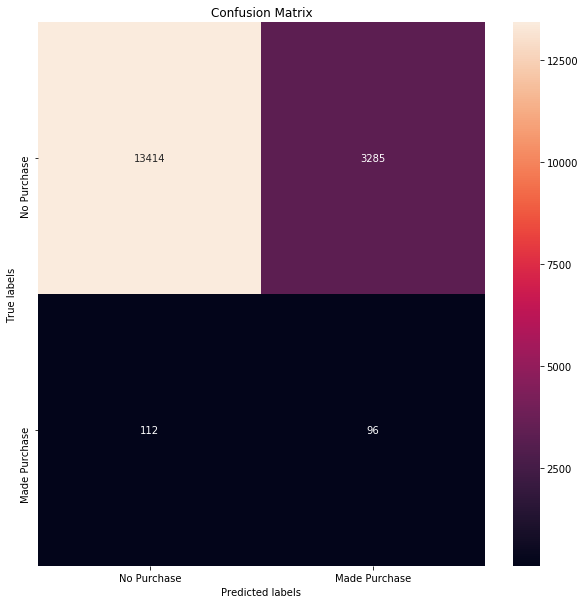

In [145]:
# confusion marix for thge validation set
valid_pred = model.predict(X_valid, ntree_limit=model.best_ntree_limit)
cm = sk.metrics.confusion_matrix(Y_valid, valid_pred)

fig, ax= plt.subplots(figsize=(10,10))
sb.heatmap(cm, annot=True, fmt='g', ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['No Purchase', 'Made Purchase']); 
ax.yaxis.set_ticklabels(['No Purchase', 'Made Purchase']);

In [185]:
def promotion_strategy(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]
                
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    test = df
    
    # Fit a model with treatment = 1 for all data points
    test['treatment'] = 1.0
    preds_treat = model.predict_proba(test, ntree_limit=model.best_ntree_limit)
    
    # Fit a model with treatment = 0 for all data points
    test['treatment'] = 0.0
    preds_cont = model.predict_proba(test, ntree_limit=model.best_ntree_limit)
    
    lift = preds_treat[:,1] - preds_cont[:,1]
    
    promotion = []
    
    for prob in lift:
        if prob > 0:
            promotion.append('Yes')
        else:
            promotion.append('No')

    promotion = np.array(promotion)
    
    return promotion

In [186]:
# find out irr and nlr on our validation set
valid_results(promotion_strategy, valid)

Nice job!  See how well your strategy worked on our valid data below!

Your irr with this strategy is 0.0142.

Your nir with this strategy is -47.40.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


C:\Users\Josh Lee\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Josh Lee\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(0.014177323450404136, -47.39999999999998)

In [187]:
# This will test your results, and provide you back some information 
# on how well your promotion_strategy will work in practice

test_results(promotion_strategy)

C:\Users\Josh Lee\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Josh Lee\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0154.

Your nir with this strategy is 42.60.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.015416668070903982, 42.59999999999991)

## Model 4: Four Quadrant Method

Like model 3, this approach is first suggested by Victor Lo in the [presentation](https://www.slideshare.net/odsc/victor-lomachinelearningpresentation). It suggested designing a model to predict an individual's probability of being in any of the 4 groups: TR, CR, TN, CN.

TR: Treatment and Responded. Basically received promotion and made a purchase
CR: Control and Responded. Did not receive a promotion but made a purchase
TN: Treatment and No Response. Received promotion but made no purchase
CN: Control and No Response. Did not receive a promotion and made no purchase

If an individual's TR probability is the highest among the four groups, it is likely that we will benefit by sending the individual a promotion to induce him or her to make a purchase.In other words, if for an individual:

$$ max[P(TR), P(CR), P(TN), P(CN)] = P(TR)$$

we should send a promotion.

This model achieved an IRR of 1.56\% and NLR of -\\$0.30 on the validation set, and an IRR of 1.55\% and NLR of \\$5.90 on the test set. This model's performance among the validation and test set is relatively stable, but it certainly did not generate very favourable results. Still, it does seem to produce a small positive NLR on the test set.

Alternative models, feature generation, and upsampling techniques can be tried to improve the results.

In [75]:
train_data = pd.read_csv('./training.csv')
test_data = pd.read_csv('./Test.csv')

In [76]:
target = []
for index, row in train_data.iterrows():
    if (row['Promotion'] == "Yes") & (row['purchase'] == 1):
        # TR group
        target.append(0)
    elif (row['Promotion'] == "No") & (row['purchase'] == 1):
        # CR group
        target.append(1)
    elif (row['Promotion'] == "Yes") & (row['purchase'] == 0):
        # TN group
        target.append(2)
    else: #CN group
        target.append(3)

train_data['target'] = target
train_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7,target
0,1,No,0,2,30.443518,-1.165083,1,1,3,2,3
1,3,No,0,3,32.159350,-0.645617,2,3,2,2,3
2,4,No,0,2,30.431659,0.133583,1,1,4,2,3
3,5,No,0,0,26.588914,-0.212728,2,1,4,2,3
4,8,Yes,0,3,28.044332,-0.385883,1,1,2,2,2


In [77]:
train, valid = sk.model_selection.train_test_split(train_data, test_size=0.2,random_state=42)

features = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7']

Y_train = train['target']
X_train = train[features]

Y_valid = valid['target']
X_valid = valid[features]

In [78]:
Y_train.value_counts()

3    33444
2    33351
0      580
1      252
Name: target, dtype: int64

In [79]:
# up sample with SMOTE
sm = SMOTE({0:33444, 1:33444, 2:33444, 3:33444}, random_state=42)
X_train_upsamp, Y_train_upsamp = sm.fit_sample(X_train, Y_train)
    
X_train_upsamp = pd.DataFrame(X_train_upsamp, columns=features)

Y_train_upsamp = pd.Series(Y_train_upsamp)
Y_train_upsamp.value_counts()

3    33444
2    33444
1    33444
0    33444
dtype: int64

In [80]:
X_train_upsamp.head()

,V1,V2,V3,V4,V5,V6,V7
0,3.0,34.470493,-1.078506,1.0,1.0,1.0,2.0
1,1.0,28.065819,-1.165083,1.0,1.0,3.0,1.0
2,1.0,27.142590,-1.511395,1.0,3.0,3.0,2.0
3,3.0,28.782344,-1.078506,1.0,1.0,1.0,2.0
4,2.0,39.605508,-0.645617,2.0,3.0,1.0,2.0


In [81]:
eval_set = [(X_train_upsamp, Y_train_upsamp), (X_valid, Y_valid)]
model = xgb.XGBClassifier(learning_rate = 0.1,\
                          num_class=4,\
                                  max_depth = 7,\
                                  min_child_weight = 5,\
                                  objective = 'multi:softmax',\
                                  seed = 42,\
                                  gamma = 0.1,\
                                  silent = True)
model.fit(X_train_upsamp, Y_train_upsamp, eval_set=eval_set,\
                    eval_metric="mlogloss", verbose=True, early_stopping_rounds=30)

[0]	validation_0-mlogloss:1.33954	validation_1-mlogloss:1.35545
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 30 rounds.
[1]	validation_0-mlogloss:1.2983	validation_1-mlogloss:1.32799
[2]	validation_0-mlogloss:1.26209	validation_1-mlogloss:1.30371
[3]	validation_0-mlogloss:1.22944	validation_1-mlogloss:1.28116
[4]	validation_0-mlogloss:1.19955	validation_1-mlogloss:1.26115
[5]	validation_0-mlogloss:1.17269	validation_1-mlogloss:1.24233
[6]	validation_0-mlogloss:1.14754	validation_1-mlogloss:1.22489
[7]	validation_0-mlogloss:1.12463	validation_1-mlogloss:1.20859
[8]	validation_0-mlogloss:1.10321	validation_1-mlogloss:1.19388
[9]	validation_0-mlogloss:1.08088	validation_1-mlogloss:1.1792
[10]	validation_0-mlogloss:1.06147	validation_1-mlogloss:1.16579
[11]	validation_0-mlogloss:1.04484	validation_1-mlogloss:1.1538
[12]	validation_0-mlogloss:1.02803	validation_1-mlogloss:1.1426
[1

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0.1, learning_rate=0.1, max_delta_step=0,
       max_depth=7, min_child_weight=5, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, num_class=4, objective='multi:softprob',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=42, silent=True, subsample=1)

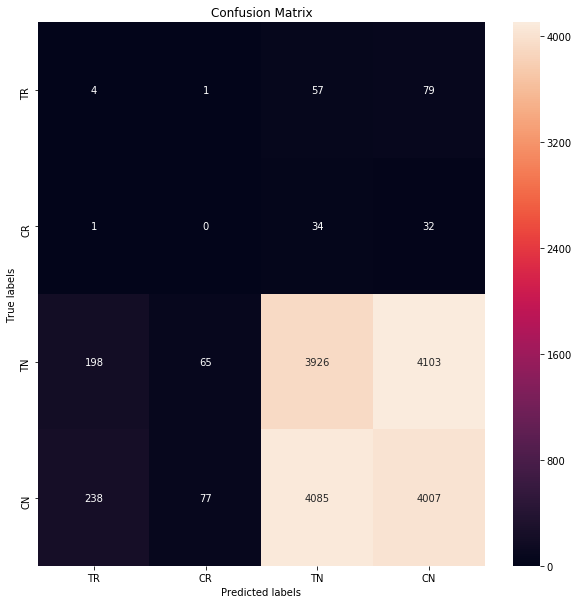

In [95]:
# confusion marix for thge validation set
# Note:
# TR: treatment and respond group (received promotion and made purchase)
# CR: control and respond group (did not receive promotion but made purchase)
# TN: treatment and no respond group (received promotion but did not made purchase)
# CR: control and no respond group (did not receive promotion and made no purchase)
valid_pred = model.predict(X_valid, ntree_limit=model.best_ntree_limit)
cm = sk.metrics.confusion_matrix(Y_valid, valid_pred)

fig, ax= plt.subplots(figsize=(10,10))
sb.heatmap(cm, annot=True, fmt='g', ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['TR', 'CR', 'TN', 'CN']); 
ax.yaxis.set_ticklabels(['TR', 'CR', 'TN', 'CN']);

In [83]:
def promotion_strategy(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]
                
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    test = df
    
    pred = model.predict(test, ntree_limit=model.best_ntree_limit)
    
    promotion = []
    
    for pred in pred:
        if pred == 0:
            promotion.append('Yes')
        else:
            promotion.append('No')
    
    promotion = np.array(promotion)
    
    return promotion

In [84]:
# find out irr and nlr on our validation set
valid_results(promotion_strategy, valid)

Nice job!  See how well your strategy worked on our valid data below!

Your irr with this strategy is 0.0156.

Your nir with this strategy is -0.30.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.01561787977960976, -0.29999999999999716)

In [85]:
# This will test your results, and provide you back some information 
# on how well your promotion_strategy will work in practice

test_results(promotion_strategy)

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0155.

Your nir with this strategy is 5.90.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.015464544490973224, 5.900000000000006)